In [3]:
# Importing paths and modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib, pathlib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import clone

BASE = pathlib.Path.cwd().parents[0]
DATA_PROCESSED = BASE / "data" / "processed"
MODELS = BASE / "models"
REPORTS = BASE / "reports"
REPORTS.mkdir(exist_ok=True)

SYMBOLS = ["QQQ", "VFV.TO", "XEQT.TO"]  # adjust if needed
TRADING_DAYS = 252
COST_BPS = 0.0005  # 5 bps one-way

In [4]:
# Helper functions for next cells
def load_dataset(symbol: str) -> pd.DataFrame:
    df = pd.read_parquet(DATA_PROCESSED / f"{symbol}_dataset.parquet")
    return df.sort_values("date").reset_index(drop=True)

def tscv_splits(n_samples: int, n_splits=5):
    return list(TimeSeriesSplit(n_splits=n_splits).split(np.arange(n_samples)))

def equity_from_logrets(r: np.ndarray, start: float = 1.0) -> np.ndarray:
    return start * np.exp(np.nancumsum(r))

def perf_metrics(logrets: pd.Series) -> dict:
    r = logrets.dropna()
    if len(r) == 0:
        return dict(CAGR=np.nan, Vol=np.nan, Sharpe=np.nan, MaxDD=np.nan)
    cagr = r.mean() * TRADING_DAYS
    vol  = r.std(ddof=0) * np.sqrt(TRADING_DAYS)
    sharpe = cagr / vol if vol > 0 else np.nan
    eq = equity_from_logrets(r.values)
    peak = np.maximum.accumulate(eq)
    maxdd = ((eq - peak) / peak).min()
    return dict(CAGR=cagr, Vol=vol, Sharpe=sharpe, MaxDD=maxdd)

In [6]:
# Out of sample predictions with tuned models
def make_X_y(df: pd.DataFrame, task: str):
    feats = df.drop(columns=["date","y_reg","y_cls"])
    X = feats.values.astype(float)
    y = df["y_reg"].values if task=="reg" else df["y_cls"].values
    return X, y, feats.columns.tolist()

def wf_predict_with_pipeline(df: pd.DataFrame, base_pipe: Pipeline, task: str, n_splits=5) -> pd.Series:
    X, y, _ = make_X_y(df, task)
    preds = np.full(len(X), np.nan, dtype=float)
    for tr, te in tscv_splits(len(X), n_splits):
        pipe = clone(base_pipe)
        pipe.fit(X[tr], y[tr])
        preds[te] = pipe.predict(X[te]) if task=="reg" else pipe.predict_proba(X[te])[:,1]
    return pd.Series(preds, index=df.index)

# Load tuned pipelines (from Day 7)
def load_tuned(symbol: str, kind: str) -> Pipeline:
    b = joblib.load(MODELS / f"{symbol}_{kind}.pkl")
    return b["model"]

# Baselines (for comparison)
baseline_ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
baseline_hgb   = Pipeline([("hgb", HistGradientBoostingRegressor())])
baseline_logit = Pipeline([("scaler", StandardScaler()), ("logit", LogisticRegression(max_iter=200, class_weight="balanced"))])

In [7]:
# function that creates a predictions frame for each fund symbol

def preds_frame(symbol: str, n_splits=5, use_tuned=True) -> pd.DataFrame:
    df = load_dataset(symbol)
    out = pd.DataFrame({"date": df["date"], "y_reg": df["y_reg"]})

    if use_tuned:
        ridge = load_tuned(symbol, "ridge_reg_tuned")
        hgb   = load_tuned(symbol, "hgb_reg_tuned")
        logit = load_tuned(symbol, "logit_cls_tuned")
    else:
        ridge, hgb, logit = baseline_ridge, baseline_hgb, baseline_logit

    out["ridge_pred"] = wf_predict_with_pipeline(df, ridge, task="reg", n_splits=n_splits).values
    out["hgb_pred"]   = wf_predict_with_pipeline(df, hgb,   task="reg", n_splits=n_splits).values
    out["logit_proba"]= wf_predict_with_pipeline(df, logit, task="cls", n_splits=n_splits).values
    return out.dropna().reset_index(drop=True)

frames = {sym: preds_frame(sym, n_splits=5, use_tuned=True) for sym in SYMBOLS}
for s, fr in frames.items():
    print(s, fr.shape, fr["date"].min().date(), "→", fr["date"].max().date())
    display(fr.head(3))

QQQ (5380, 5) 2004-04-06 → 2025-08-22


,date,y_reg,ridge_pred,hgb_pred,logit_proba
0,2004-04-06,-0.001082,-0.002077,-0.000821,0.479268
1,2004-04-07,0.000000,-0.001740,-0.000821,0.484447
2,2004-04-08,0.006207,-0.001519,-0.000821,0.496852


VFV.TO (2645, 5) 2015-02-09 → 2025-08-22


,date,y_reg,ridge_pred,hgb_pred,logit_proba
0,2015-02-09,0.019448,0.000094,0.001312,0.310692
1,2015-02-10,0.004965,0.000048,0.001654,0.318385
2,2015-02-11,-0.001940,0.000100,0.000860,0.414206


XEQT.TO (1230, 5) 2020-09-29 → 2025-08-22


,date,y_reg,ridge_pred,hgb_pred,logit_proba
0,2020-09-29,-0.002317,0.000159,0.001196,0.475623
1,2020-09-30,0.003706,0.001489,0.000364,0.493816
2,2020-10-01,-0.002084,0.000673,0.000923,0.456508


In [10]:
# Functions that aim to sweep through thresholds
def simulate_from_signal(df_like: pd.DataFrame, signal: pd.Series, kind: str,
                         thr: float, cost_bps=COST_BPS) -> pd.DataFrame:
    pos = (signal > thr).astype(int) if kind=="reg" else (signal > thr).astype(int)
    trades = pos.diff().abs().fillna(0.0)
    costs = cost_bps * trades
    r_strat = pos * df_like["y_reg"] - costs
    return pd.DataFrame({"date": df_like["date"], "r_strat": r_strat})

def choose_threshold(frame: pd.DataFrame, signal_col: str, kind: str,
                     thr_grid, cal_frac=0.8, objective="Sharpe", cost_bps=COST_BPS):
    """
    Returns dict(best_thr_cal, cal_metrics, test_metrics).
    We split OOS data by time into Calibration (first cal_frac) and Test (rest).
    """
    n = len(frame)
    split = int(n * cal_frac)
    cal = frame.iloc[:split].copy()
    tes = frame.iloc[split:].copy()

    best_thr, best_val = None, -np.inf
    best_metrics_cal = None

    for thr in thr_grid:
        run = simulate_from_signal(cal, cal[signal_col], kind, thr, cost_bps)
        m = perf_metrics(run["r_strat"])
        val = m["Sharpe"] if objective=="Sharpe" else m["CAGR"]
        if np.isfinite(val) and val > best_val:
            best_val = val
            best_thr = thr
            best_metrics_cal = m

    # Evaluate on Test with chosen thr
    run_test = simulate_from_signal(tes, tes[signal_col], kind, best_thr, cost_bps)
    m_test = perf_metrics(run_test["r_strat"])

    return {
        "best_thr_cal": best_thr,
        "cal_metrics": best_metrics_cal,
        "test_metrics": m_test,
        "cal_dates": (cal["date"].iloc[0], cal["date"].iloc[-1]),
        "test_dates": (tes["date"].iloc[0], tes["date"].iloc[-1]),
        "cal_curve": run_test,  # (we'll rebuild full curves separately for plotting)
    }


In [11]:
# Sweeping through thresholds for all models and all symbols
results = []

# Reasonable grids:
reg_grid  = np.round(np.linspace(-0.0005, 0.0005, 21), 6)   # ~ -5bps .. +5bps
cls_grid  = np.round(np.linspace(0.45, 0.65, 21), 3)        # 0.45 .. 0.65

for sym, fr in frames.items():
    # Ridge (reg)
    rid = choose_threshold(fr, "ridge_pred", "reg", reg_grid, cal_frac=0.8, objective="Sharpe", cost_bps=COST_BPS)
    results.append(dict(symbol=sym, model="ridge_tuned", best_thr=rid["best_thr_cal"],
                        cal_start=rid["cal_dates"][0], cal_end=rid["cal_dates"][1],
                        test_start=rid["test_dates"][0], test_end=rid["test_dates"][1],
                        cal_CAGR=rid["cal_metrics"]["CAGR"], cal_Sharpe=rid["cal_metrics"]["Sharpe"],
                        test_CAGR=rid["test_metrics"]["CAGR"], test_Sharpe=rid["test_metrics"]["Sharpe"]))

    # HGB (reg)
    hgb = choose_threshold(fr, "hgb_pred", "reg", reg_grid, cal_frac=0.8, objective="Sharpe", cost_bps=COST_BPS)
    results.append(dict(symbol=sym, model="hgb_tuned", best_thr=hgb["best_thr_cal"],
                        cal_start=hgb["cal_dates"][0], cal_end=hgb["cal_dates"][1],
                        test_start=hgb["test_dates"][0], test_end=hgb["test_dates"][1],
                        cal_CAGR=hgb["cal_metrics"]["CAGR"], cal_Sharpe=hgb["cal_metrics"]["Sharpe"],
                        test_CAGR=hgb["test_metrics"]["CAGR"], test_Sharpe=hgb["test_metrics"]["Sharpe"]))

    # Logistic (cls)
    logi = choose_threshold(fr, "logit_proba", "cls", cls_grid, cal_frac=0.8, objective="Sharpe", cost_bps=COST_BPS)
    results.append(dict(symbol=sym, model="logit_tuned", best_thr=logi["best_thr_cal"],
                        cal_start=logi["cal_dates"][0], cal_end=logi["cal_dates"][1],
                        test_start=logi["test_dates"][0], test_end=logi["test_dates"][1],
                        cal_CAGR=logi["cal_metrics"]["CAGR"], cal_Sharpe=logi["cal_metrics"]["Sharpe"],
                        test_CAGR=logi["test_metrics"]["CAGR"], test_Sharpe=logi["test_metrics"]["Sharpe"]))

summary9 = pd.DataFrame(results)
display(summary9)

out_csv = REPORTS / "day9_threshold_selection_summary.csv"
summary9.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,symbol,model,best_thr,cal_start,cal_end,test_start,test_end,cal_CAGR,cal_Sharpe,test_CAGR,test_Sharpe
0,QQQ,ridge_tuned,-0.00045,2004-04-06,2021-05-11,2021-05-12,2025-08-22,0.101667,0.639442,0.074606,0.409633
1,QQQ,hgb_tuned,-0.00050,2004-04-06,2021-05-11,2021-05-12,2025-08-22,0.133718,0.899715,0.119488,0.557347
2,QQQ,logit_tuned,0.49000,2004-04-06,2021-05-11,2021-05-12,2025-08-22,0.142944,0.746220,0.133215,0.641420
3,VFV.TO,ridge_tuned,-0.00050,2015-02-09,2023-07-14,2023-07-17,2025-08-22,0.104771,0.647826,0.106998,0.802050
4,VFV.TO,hgb_tuned,0.00015,2015-02-09,2023-07-14,2023-07-17,2025-08-22,0.074625,0.502753,0.131670,0.985181
5,VFV.TO,logit_tuned,0.45000,2015-02-09,2023-07-14,2023-07-17,2025-08-22,0.091819,0.558841,0.221465,1.513491
6,XEQT.TO,ridge_tuned,-0.00050,2020-09-29,2024-08-29,2024-08-30,2025-08-22,0.019624,0.193681,0.079228,0.640725
7,XEQT.TO,hgb_tuned,-0.00050,2020-09-29,2024-08-29,2024-08-30,2025-08-22,0.093822,0.844411,0.144899,1.200753
8,XEQT.TO,logit_tuned,0.47000,2020-09-29,2024-08-29,2024-08-30,2025-08-22,0.088016,0.783200,0.125840,0.855570


Saved: /Users/itzronald/Desktop/trend-predictor/reports/day9_threshold_selection_summary.csv


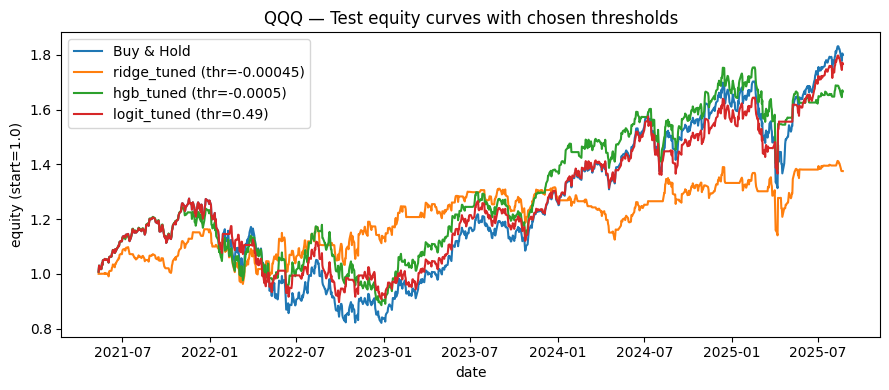

Saved: /Users/itzronald/Desktop/trend-predictor/reports/day9_QQQ_test_equity.png


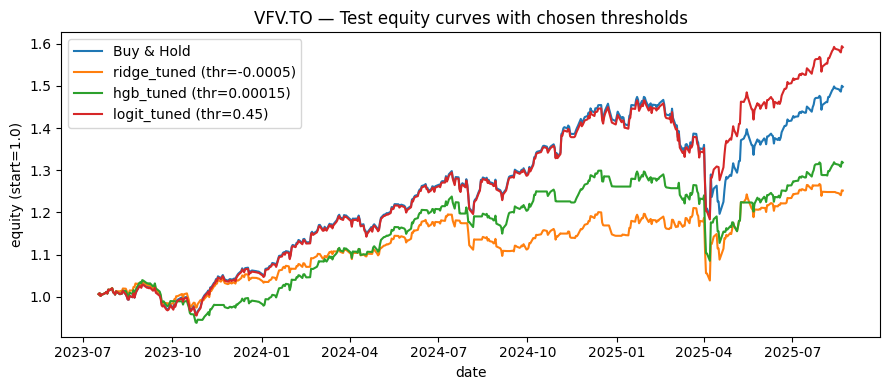

Saved: /Users/itzronald/Desktop/trend-predictor/reports/day9_VFV.TO_test_equity.png


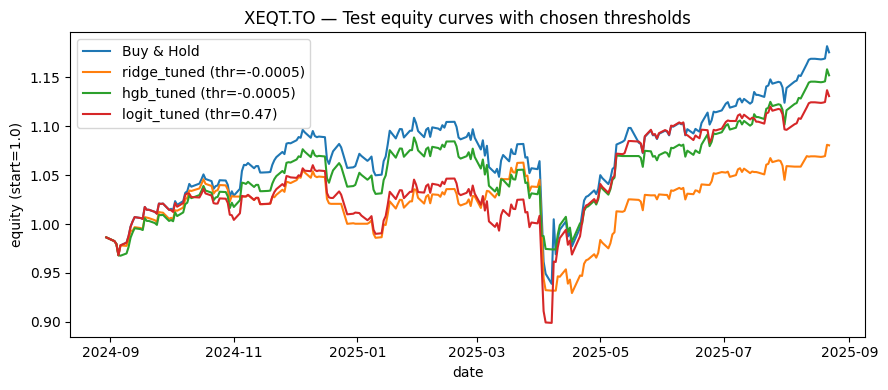

Saved: /Users/itzronald/Desktop/trend-predictor/reports/day9_XEQT.TO_test_equity.png


In [12]:
# Equity plot on test sample with best chosen thresholds
def plot_test_equity(symbol: str, fr: pd.DataFrame, bests: pd.DataFrame):
    sel = bests[bests["symbol"] == symbol]
    sub = fr.copy()

    plt.figure(figsize=(9,4))
    # Buy & hold equity over the test window (for reference)
    split = int(len(sub) * 0.8)
    tes = sub.iloc[split:].copy()
    eq_bh = equity_from_logrets(tes["y_reg"].values, 1.0)
    plt.plot(tes["date"], eq_bh, label="Buy & Hold")

    for model, col in [("ridge_tuned","ridge_pred"), ("hgb_tuned","hgb_pred"), ("logit_tuned","logit_proba")]:
        row = sel[sel["model"] == model].iloc[0]
        thr = row["best_thr"]
        kind = "cls" if "logit" in model else "reg"
        run = simulate_from_signal(tes.assign(date=tes["date"]), tes[col], kind, thr, cost_bps=COST_BPS)
        eq = equity_from_logrets(run["r_strat"].values, 1.0)
        plt.plot(tes["date"], eq, label=f"{model} (thr={thr})")

    plt.title(f"{symbol} — Test equity curves with chosen thresholds")
    plt.xlabel("date"); plt.ylabel("equity (start=1.0)")
    plt.legend()
    plt.tight_layout()
    fname = REPORTS / f"day9_{symbol}_test_equity.png"
    plt.savefig(fname, dpi=150)
    plt.show()
    print("Saved:", fname)

for sym in SYMBOLS:
    plot_test_equity(sym, frames[sym], summary9)
